# Service Requests:

## Why?
[Studies](https://www.reinvestment.com/wp-content/uploads/2017/08/ReinvestmentFund_PA_District_Perf_Report.pdf) show a 1 percentage-point improvement in the share of students scoring “proficient or advanced” in reading or math was associated with roughly $513 to $620 increase in average home sales price across a district

[Studies](https://pmc.ncbi.nlm.nih.gov/articles/PMC5035645/?utm_source=chatgpt.com) show that there is a strong correlation with home values and neighborhood quality measures (such as poverty rate and observed property characteristics)

## Goal
Use house resale values to compare Pittsburgh neighborhoods. Metric (for now): Average sale price (last 3 years), valid sales only.
Dataset: https://data.wprdc.org/dataset/real-estate-sales

In [21]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.ticker as mticker

url_311 = "https://tools.wprdc.org/downstream/29462525-62a6-45bf-9b5e-ad2e1c06348d"
df311 = pd.read_csv(url_311, low_memory=False)

print("Rows:", len(df311))
print(df311.columns)

Rows: 815417
Index(['_id', 'group_id', 'num_requests', 'parent_closed', 'status_name',
       'status_code', 'dept', 'request_type_name', 'request_type_id',
       'create_date_et', 'create_date_utc', 'last_action_et',
       'last_action_utc', 'closed_date_et', 'closed_date_utc', 'origin',
       'street', 'cross_street', 'street_id', 'cross_street_id', 'city',
       'neighborhood', 'census_tract', 'council_district', 'ward',
       'police_zone', 'latitude', 'longitude', 'geo_accuracy'],
      dtype='object')


In [23]:
# Clean 311 data

date_col = "create_date_et"
neighborhood_col = "neighborhood"

# keep only necessary columns
work_311 = df311[[date_col, neighborhood_col]].copy()

# convert date column to datetime
work_311[date_col] = pd.to_datetime(work_311[date_col], errors="coerce")

# drop rows missing date or neighborhood
work_311 = work_311.dropna(subset=[date_col, neighborhood_col])

# standardize neighborhood names
work_311[neighborhood_col] = work_311[neighborhood_col].str.strip().str.title()

print("Rows after clean:", len(work_311))
work_311.head()

Rows after clean: 778045


,create_date_et,neighborhood
96,2022-04-24 09:56:00,Central Business District
196,2020-05-11 11:32:00,Highland Park
309,2021-10-31 09:13:00,Highland Park
375,2022-04-01 07:33:00,Highland Park
529,2019-02-24 11:15:00,Elliott


In [24]:
# Filter to last 3 years
latest_date = work_311[date_col].max()
cutoff_date = latest_date - pd.DateOffset(years=3)

recent_311 = work_311[work_311[date_col] >= cutoff_date].copy()
print("Rows in last 3 years:", len(recent_311))

Rows in last 3 years: 265235


In [28]:
# count 311 requests per neighborhood (last 3 years)
counts = (
    recent_311
    .groupby(neighborhood_col)[date_col]
    .count()
    .sort_values(ascending=False)
)

counts.head(10)

neighborhood
South Side Flats             12558
Central Business District    11551
South Side Slopes            10803
Squirrel Hill South          10491
Brookline                    10122
Carrick                       9355
Bloomfield                    8271
Crafton Heights               7120
Mount Washington              6822
Shadyside                     6482
Name: create_date_et, dtype: int64

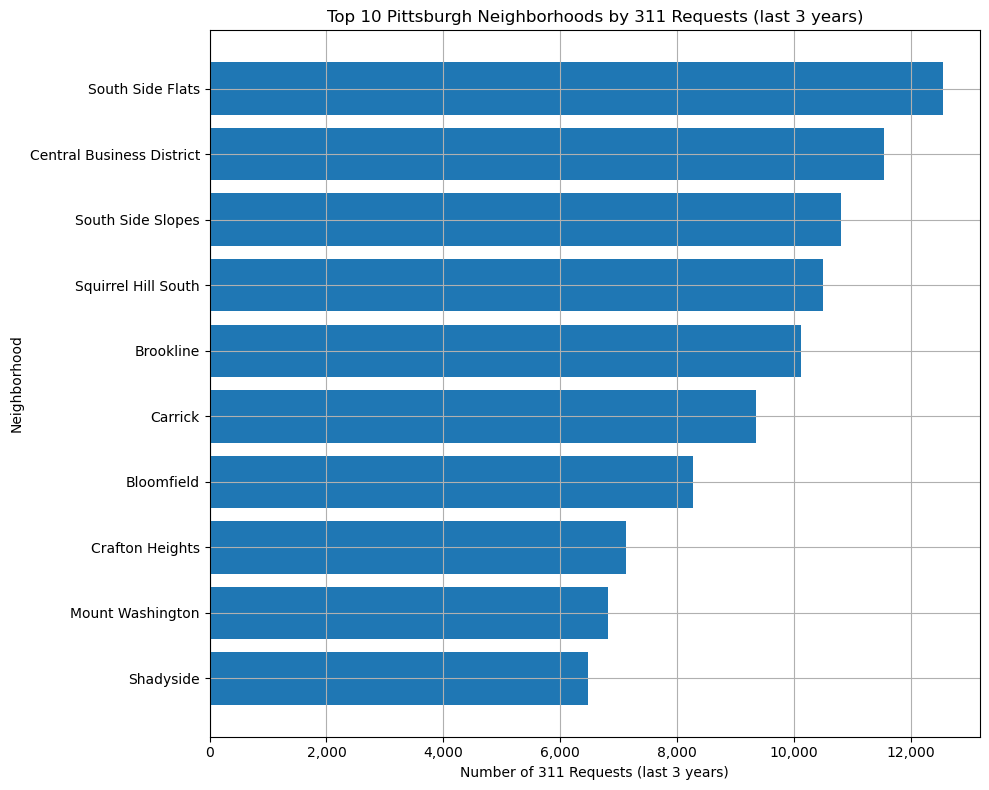

In [29]:
# plot top 10 neighborhoods by request count
top_counts = counts.head(10)[::-1]
# reverse for horizontal bar chart ^

fig, ax = plt.subplots(figsize=(10, 8))

ax.barh(top_counts.index, top_counts.values)

ax.set_xlabel("Number of 311 Requests (last 3 years)")
ax.set_ylabel("Neighborhood")
ax.set_title(f"Top 10 Pittsburgh Neighborhoods by 311 Requests (last 3 years)")

# Optional: format x-axis with thousands separator
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))

plt.tight_layout()
plt.show()

In [30]:
# nicely formatted counts
counts_fmt = counts.map("{:,.0f}".format)
print("Top 10 neighborhoods by 311 requests (last 3 years):\n")
print(counts_fmt.head(10))

Top 10 neighborhoods by 311 requests (last 3 years):

neighborhood
South Side Flats             12,558
Central Business District    11,551
South Side Slopes            10,803
Squirrel Hill South          10,491
Brookline                    10,122
Carrick                       9,355
Bloomfield                    8,271
Crafton Heights               7,120
Mount Washington              6,822
Shadyside                     6,482
Name: create_date_et, dtype: object
